<a href="https://colab.research.google.com/github/ArtemPavlovich/HSE_AML_course/blob/master/Bayesian_Methods/week4/Copy_of_Vae_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First things first
* Click **File -> Save a copy in Drive** and click **Open in new tab** in the pop-up window to save your progress in Google Drive.
* Click **Runtime -> Change runtime type** and select **GPU** in Hardware accelerator box to enable faster GPU training.

# Variational Autoencoder

In this assignment, you will build Variational Autoencoder, train it on the MNIST dataset, and play with its architecture and hyperparameters.

### Setup
Loading auxiliary files and importing the necessary libraries.

In [0]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    print("Downloading Colab files")
    ! shred -u setup_google_colab.py
    ! wget https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/setup_google_colab.py -O setup_google_colab.py
    import setup_google_colab
    setup_google_colab.load_data_week5()

shred: setup_google_colab.py: failed to open for writing: No such file or directory
--2020-03-05 15:40:49--  https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1254 (1.2K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   1.22K  --.-KB/s    in 0s      

2020-03-05 15:40:49 (313 MB/s) - ‘setup_google_colab.py’ saved [1254/1254]

https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/week5/w5_grader.py w5_grader.py
https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/week5/test_data.npz test_data.npz


In [0]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
tfd = tfp.distributions
from keras.layers import Input, Dense, Lambda, InputLayer, concatenate, Conv2D, Conv2DTranspose, Reshape, Flatten, BatchNormalization, Activation
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from w5_grader import VAEGrader

Using TensorFlow backend.


In [0]:
# Start tf session so we can run code.
sess = tf.InteractiveSession()
# Connect keras to the created session.
K.set_session(sess)

### Grading
We will create a grader instance below and use it to collect your answers. Note that these outputs will be stored locally inside grader and will be uploaded to the platform only after running submit function in the last part of this assignment. If you want to make a partial submission, you can run that cell anytime you want.

In [0]:
grader = VAEGrader()

### Variational Autoencoder

Recall that Variational Autoencoder is a probabilistic model of data based on a continious mixture of distributions. In the lecture we covered the mixture of gaussians case, but here we will apply VAE to binary MNIST images (each pixel is either black or white). To better model binary data we will use a continuous mixture of binomial distributions: $p(x \mid w) = \int p(x \mid t, w) p(t) dt$, where the prior distribution on the latent code $t$ is standard normal $p(t) = \mathcal{N}(0, I)$, but probability that $(i, j)$-th pixel is black equals to $(i, j)$-th output of the decoder neural detwork: $p(x_{i, j} \mid t, w) = \text{decoder}(t, w)_{i, j}$.

To train this model we would like to maximize marginal log-likelihood of our dataset $\max_w \log p(X \mid w)$, but it's very hard to do computationally, so instead we maximize the Variational Lower Bound w.r.t. both the original parameters $w$ and variational distribution $q$ which we define as encoder neural network with parameters $\phi$ which takes input image $x$ and outputs parameters of the gaussian distribution $q(t \mid x, \phi)$: $\log p(X \mid w) \geq \mathcal{L}(w, \phi) \rightarrow \max_{w, \phi}$.

So overall our model looks as follows: encoder takes an image $x$, produces a distribution over latent codes $q(t \mid x)$ which should approximate the posterior distribution $p(t \mid x)$ (at least after training), samples a point from this distribution $\widehat{t} \sim q(t \mid x, \phi)$, and finally feeds it into a decoder that outputs a distribution over images.

![](https://github.com/hse-aml/bayesian-methods-for-ml/blob/master/week5/VAE.png?raw=1)

In the lecture, we also discussed that variational lower bound has an expected value inside which we are going to approximate with sampling. But it is not trivial since we need to differentiate through this approximation. However, we learned about _reparametrization trick_ which suggests instead of sampling from distribution $\widehat{t} \sim q(t \mid x, \phi)$ sample from a distribution which doesn't depend on any parameters, e.g. standard normal, and then deterministically transform this sample to the desired one: $\varepsilon \sim \mathcal{N}(0, I); ~~\widehat{t} = m(x, \phi) + \varepsilon \sigma(x, \phi)$. This way we don't have to worry about our stochastic gradient being biased and can straightforwardly differentiate our loss w.r.t. all the parameters while treating the current sample $\varepsilon$ as constant.




### Negative Variational Lower Bound

**Task 1** Derive and implement Variational Lower Bound for the continuous mixture of Binomial distributions.

**Note** that in lectures we discussed maximizing the VLB (which is typically a negative number), but in this assignment, for convenience, we will **minimize** the **negated** version of VLB (which will be a positive number) instead of maximizing the usual VLB. In what follows we always talk about _negated_ VLB, even when we use the term VLB for short.

**Also note** that to pass the test, your code should work with any mini-batch size.

To do that, we need a stochastic estimate of VLB: 
$$\text{VLB} = \sum_{i=1}^N \text{VLB}_i \approx \frac{N}{M}\sum_{i_s}^M \text{VLB}_{i_s}$$
where $N$ is the dataset size, $\text{VLB}_i$ is the term of VLB corresponding to the $i$-th object, and $M$ is the mini-batch size. But instead of this stochastic estimate of the full VLB we will use an estimate of the negated VLB normalized by the dataset size, i.e. in the function below you need to return average across the mini-batch $-\frac{1}{M}\sum_{i_s}^M \text{VLB}_{i_s}$. People usually optimize this normalized version of VLB since it doesn't depend on the dataset set - you can write VLB function once and use it for different datasets - the dataset size won't affect the learning rate too much. The correct value for this normalized negated VLB should be around $100 - 170$ in the example below.

In [0]:
def vlb_binomial(x, x_decoded_mean, t_mean, t_log_var):
    """Returns the value of negative Variational Lower Bound
    
    The inputs are tf.Tensor
        x: (batch_size x number_of_pixels) matrix with one image per row with zeros and ones
        x_decoded_mean: (batch_size x number_of_pixels) mean of the distribution p(x | t), real numbers from 0 to 1
        t_mean: (batch_size x latent_dim) mean vector of the (normal) distribution q(t | x)
        t_log_var: (batch_size x latent_dim) logarithm of the variance vector of the (normal) distribution q(t | x)
    
    Returns:
        A tf.Tensor with one element (averaged across the batch), VLB
    """
    ### YOUR CODE HERE
    
    log_prob_out = tf.reduce_sum(tf.math.log(x_decoded_mean+1e-19) * x  + (1 - x) * tf.math.log(1 - x_decoded_mean), axis = 1)
    
    KL = 0.5 * tf.reduce_sum(-t_log_var + tf.math.square(t_mean) + tf.math.exp(t_log_var) - 1, axis = 1)

    VLB = tf.reduce_mean(log_prob_out - KL)

    return -VLB


In [0]:
# x_dec = tf.constant(np.array([[.2,.3,.4,.3],[.5,.6,.7,.3]], dtype='float32'))
# t_mean = tf.constant(np.array([[.2,.3,.3],[.5,.6,.3]], dtype='float32'))

# output = tfd.Bernoulli(probs=x_dec, name='output')
# epsilon = tfd.MultivariateNormalDiag(loc=tf.zeros(t_mean.shape))
# prior_t = tfd.MultivariateNormalDiag(loc=tf.zeros(t_mean.shape))

# log_prob_out = tf.reduce_sum(output.log_prob(x_dec))
# latent = tfp.bijectors.Affine(shift=t_mean, scale_diag=t_mean)
# latent = latent(epsilon)
# # expect = tf.reduce_sum(latent.sample(), axis=0)
# # expect
# latent.sample()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<tf.Tensor 'affineMultivariateNormalDiag/sample/affine/forward/add:0' shape=(2, 3) dtype=float32>

In [0]:
grader.submit_vlb(sess, vlb_binomial)

Current answer for task 1 (vlb) is: 157.59705


## Encoder / decoder definition

**Task 2** Read the code below that defines encoder and decoder networks and implement sampling with reparametrization trick in the provided space.

In [0]:
batch_size = 100
original_dim = 784 # Number of pixels in MNIST images.
conv_dim = (28,28,1)
latent_dim = 10 # d, dimensionality of the latent code t.
intermediate_dim = 512 # Size of the hidden layer.
epochs = 20

x = Input(batch_shape=(batch_size, original_dim))
x_conv = Input(batch_shape=(batch_size, *conv_dim))

def create_encoder(input_dim):
    # Encoder network.
    # We instantiate these layers separately so as to reuse them later
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer([input_dim]))
    encoder.add(Dense(intermediate_dim, activation='relu'))
    encoder.add(Dense(intermediate_dim, activation='relu'))
    encoder.add(Dense(2 * latent_dim))
    return encoder

def create_encoder_conv(input_dim):
  encoder = Sequential(name='encoder_conv')
  encoder.add(InputLayer(input_dim))
  encoder.add(Conv2D(filters = 64, kernel_size=4, strides=2, padding='same', use_bias=False))
  encoder.add(BatchNormalization(axis=3))
  encoder.add(Activation('relu'))
  encoder.add(Conv2D(filters = 128, kernel_size=4, strides=2, padding='same', use_bias=False))
  encoder.add(BatchNormalization(axis=3))
  encoder.add(Activation('relu'))
  # encoder.add(Conv2D(filters = 16, kernel_size=4, strides=7))
  encoder.add(Flatten())
  # encoder.add(Dense(intermediate_dim, activation='relu'))
  encoder.add(Dense(2 * latent_dim, name='output'))
  return encoder

get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])

encoder = create_encoder(original_dim)
encoder_conv = create_encoder_conv(conv_dim)

h = encoder(x)
h_conv = encoder_conv(x_conv)

t_mean = get_t_mean(h)
t_log_var = get_t_log_var(h)

t_mean_conv = get_t_mean(h_conv)
t_log_var_conv = get_t_log_var(h_conv)

# Sampling from the distribution 
#     q(t | x) = N(t_mean, exp(t_log_var))
# with reparametrization trick.
def sampling(args):
    """Returns sample from a distribution N(args[0], diag(args[1]))
    
    The sample should be computed with reparametrization trick.
    
    The inputs are tf.Tensor
        args[0]: (batch_size x latent_dim) mean of the desired distribution
        args[1]: (batch_size x latent_dim) logarithm of the variance vector of the desired distribution
    
    Returns:
        A tf.Tensor of size (batch_size x latent_dim), the samples.
    """
    t_mean, t_log_var = args
    # YOUR CODE HERE
    epsilon = tfd.MultivariateNormalDiag(loc=tf.zeros(t_mean.shape))
    latent = tfp.bijectors.Affine(shift=t_mean,  scale_diag=tf.math.exp(.5 * t_log_var))
    latent = latent(epsilon)
    return latent.sample()

t = Lambda(sampling)([t_mean, t_log_var])
t_conv = Lambda(sampling)([t_mean_conv, t_log_var_conv])

def create_decoder(input_dim):
    # Decoder network
    # We instantiate these layers separately so as to reuse them later
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer([input_dim]))
    decoder.add(Dense(intermediate_dim, activation='relu'))
    decoder.add(Dense(intermediate_dim, activation='relu'))
    decoder.add(Dense(original_dim, activation='sigmoid'))
    return decoder

def create_decoder_conv(input_dim):
  decoder = Sequential(name='decoder_conv')
  decoder.add(InputLayer([input_dim]))
  # decoder.add(Dense(intermediate_dim, activation='relu'))
  decoder.add(Dense(128 * 7 * 7))
  decoder.add(Reshape((7, 7, 128)))
  decoder.add(Conv2DTranspose(kernel_size=4, filters=128, strides=2, padding='same', use_bias=False, name='deconv1'))
  decoder.add(BatchNormalization(axis=3))
  decoder.add(Activation('relu'))
  decoder.add(Conv2DTranspose(kernel_size=4, filters=64, strides=2, padding='same', use_bias=False, name='deconv2'))
  # decoder.add(BatchNormalization(axis=3))
  decoder.add(Activation('sigmoid'))
  decoder.add(Flatten())                                               
  return decoder

decoder = create_decoder(latent_dim)
decoder_conv = create_decoder_conv(latent_dim)

x_decoded_mean = decoder(t)
x_decoded_mean_conv = decoder(t_conv)

In [0]:
# encoder = Sequential(name='encoder_conv')
# encoder.add(InputLayer([original_dim]))
# encoder.add(Reshape((28,28,1),name='reshape'))
# encoder.add(Conv2D(filters = 16, kernel_size=4, strides=4,name='conv2d'))
print(decoder_conv.get_layer(name='deconv2').output_shape)

(None, 28, 28, 128)


In [0]:
grader.submit_samples(sess, sampling)

Current answer for task 2.1 (samples mean) is: -0.11856712
Current answer for task 2.2 (samples var) is: 0.036918394


## Training the model

**Task 3** Run the cells below to train the model with the default settings. Modify the parameters to get better results. Especially pay attention to the encoder/decoder architectures (e.g. using more layers, maybe making them convolutional), learning rate, and the number of epochs.

In [0]:
loss = vlb_binomial(x, x_decoded_mean, t_mean, t_log_var)
loss_conv = vlb_binomial(tf.reshape(x_conv,[batch_size, original_dim]), x_decoded_mean_conv, t_mean_conv, t_log_var_conv)

vae = Model(x, x_decoded_mean)
vae_conv = Model(x_conv, x_decoded_mean_conv)
# Keras will provide input (x) and output (x_decoded_mean) to the function that
# should construct loss, but since our function also depends on other
# things (e.g. t_means), it is easier to build the loss in advance and pass
# a function that always returns it.
vae.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss=lambda x, y: loss)
vae_conv.compile(optimizer=keras.optimizers.RMSprop(lr=0.0005), loss=lambda x, y: loss_conv)

#### Load and prepare the data

In [0]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# One hot encoding.
y_train_dense = np_utils.to_categorical(y_train)
y_test_dense = np_utils.to_categorical(y_test)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train_dense = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_dense = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train_conv = np.expand_dims(x_train, -1)
x_test_conv = np.expand_dims(x_test, -1)

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
x_train[0]

#### Train the model

In [0]:
hist = vae.fit(x=x_train_dense, y=x_train_dense,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_test_dense, x_test_dense),
               verbose=2)




Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 4s - loss: 154.3643 - val_loss: 128.5341
Epoch 2/20
 - 2s - loss: 123.9353 - val_loss: 118.3319
Epoch 3/20
 - 2s - loss: 116.8701 - val_loss: 113.3403
Epoch 4/20
 - 2s - loss: 112.7932 - val_loss: 110.2821
Epoch 5/20
 - 2s - loss: 110.5094 - val_loss: 109.8257
Epoch 6/20
 - 2s - loss: 108.9407 - val_loss: 108.6266
Epoch 7/20
 - 2s - loss: 107.8275 - val_loss: 107.1457
Epoch 8/20
 - 2s - loss: 106.8896 - val_loss: 106.4917
Epoch 9/20
 - 2s - loss: 106.1683 - val_loss: 106.5859
Epoch 10/20
 - 2s - loss: 105.6177 - val_loss: 105.1449
Epoch 11/20
 - 2s - loss: 105.1338 - val_loss: 104.9884
Epoch 12/20
 - 2s - loss: 104.7009 - val_loss: 105.1318
Epoch 13/20
 - 2s - loss: 104.3419 - val_loss: 104.1090
Epoch 14/20
 - 2s - loss: 104.0270 - val_loss: 105.0581
Epoch 15/20
 - 2s - loss: 103.7694 - val_loss: 104.3602
Epoch 16/20
 - 2s - loss: 103.4884 - val_loss: 104.2549
Epoch 17/20
 - 2s - loss: 103.2587 - val_loss: 104.1015
Epoc

In [0]:
hist_conv = vae_conv.fit(x=x_train_conv, y=x_train_conv,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_test_conv, x_test_conv),
               verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 5s - loss: 170.9484 - val_loss: 144.0125
Epoch 2/20
 - 4s - loss: 137.1612 - val_loss: 131.7223
Epoch 3/20
 - 4s - loss: 126.5266 - val_loss: 121.8394
Epoch 4/20
 - 4s - loss: 120.3990 - val_loss: 116.2351
Epoch 5/20
 - 4s - loss: 116.6513 - val_loss: 115.5647
Epoch 6/20
 - 4s - loss: 114.1845 - val_loss: 112.6354
Epoch 7/20
 - 4s - loss: 112.4741 - val_loss: 110.2018
Epoch 8/20
 - 4s - loss: 111.0140 - val_loss: 110.7527
Epoch 9/20
 - 4s - loss: 109.9416 - val_loss: 108.9519
Epoch 10/20
 - 4s - loss: 109.0383 - val_loss: 107.9690
Epoch 11/20
 - 4s - loss: 108.2429 - val_loss: 107.2603
Epoch 12/20
 - 3s - loss: 107.5876 - val_loss: 107.5954
Epoch 13/20
 - 4s - loss: 107.0325 - val_loss: 106.4121
Epoch 14/20
 - 4s - loss: 106.4678 - val_loss: 106.7121
Epoch 15/20
 - 4s - loss: 106.0432 - val_loss: 105.5011
Epoch 16/20
 - 3s - loss: 105.6660 - val_loss: 105.5600
Epoch 17/20
 - 4s - loss: 105.3062 - val_loss: 105.5158
Epoch 1

### Visualize reconstructions for train and validation data
In the picture below you can see the reconstruction ability of your network on training and validation data. In each of the two images, the left column is MNIST images and the right column is the corresponding image after passing through autoencoder (or more precisely the mean of the binomial distribution over the output images).

Note that getting the best possible reconstruction is not the point of VAE, the KL term of the objective specifically hurts the reconstruction performance. But the reconstruction should be anyway reasonable and they provide a visual debugging tool.

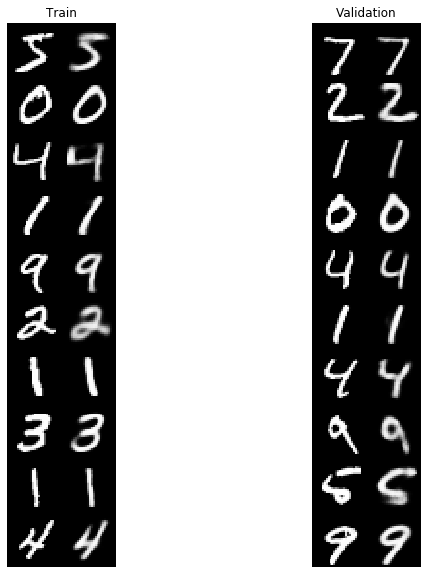

In [0]:
fig = plt.figure(figsize=(10, 10))
for fid_idx, (data, title) in enumerate(
            zip([x_train_dense, x_test_dense], ['Train', 'Validation'])):
    n = 10  # figure with 10 x 2 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * 2))
    decoded = sess.run(x_decoded_mean, feed_dict={x: data[:batch_size, :]})
    for i in range(10):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = data[i, :].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()

In [0]:
fig_conv = plt.figure(figsize=(10, 10))
for fid_idx, (data, title) in enumerate(
            zip([x_train_conv, x_test_conv], ['Train', 'Validation'])):
    n = 10  # figure with 10 x 2 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * 2))
    decoded = sess.run(x_decoded_mean_conv, feed_dict={x: data[:batch_size]})
    for i in range(10):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = data[i]
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = decoded[i].reshape(digit_size, digit_size)
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()

ValueError: ignored

<Figure size 720x720 with 0 Axes>

### Sending the results of your best model as Task 3 submission

In [0]:
grader.submit_best_val_loss(hist_conv)

Current answer for task 3 (best val loss) is: 113.8767520904541


## Hallucinating new data
**Task 4** Write code to generate new samples of images from your trained VAE. To do that you have to sample from the prior distribution $p(t)$ and then from the likelihood $p(x \mid t)$.

**Note** that the sampling you've written in Task 2 was for the variational distribution $q(t \mid x)$, while here you need to sample from the prior.

In [0]:
n_samples = 10  # To pass automatic grading please use at least 2 samples here.
# YOUR CODE HERE.

# sampled_im_mean is a tf.Tensor of size 10 x 784 with 10 random
# images sampled from the vae model.
prior_t = tfd.MultivariateNormalDiag(loc=tf.zeros([n_samples,latent_dim]))
sample_t = prior_t.sample()
# print(sess.run(sample_t))
sampled_im_mean = decoder(sample_t)

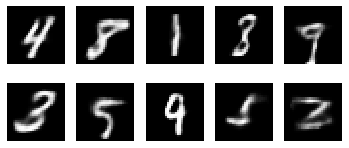

In [0]:
sampled_im_mean_np = sess.run(sampled_im_mean)
# Show the sampled images.
plt.figure()
for i in range(n_samples):
    ax = plt.subplot(n_samples // 5 + 1 , 5, i + 1)
    plt.imshow(sampled_im_mean_np[i, :].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()

In [0]:
grader.submit_hallucinating(sess, sampled_im_mean)

Current answer for task 4.1 (hallucinating mean) is: 0.13873906
Current answer for task 4.2 (hallucinating var) is: 0.107835814


# Conditional VAE

In the final task, you will modify your code to obtain Conditional Variational Autoencoder [1]. The idea is very simple: to be able to control the samples you generate, we condition all the distributions on some additional information. In our case, this additional information will be the class label (the digit on the image, from 0 to 9).

![](https://github.com/hse-aml/bayesian-methods-for-ml/blob/master/week5/CVAE.png?raw=1)

So now both the likelihood and the variational distributions are conditioned on the class label: $p(x \mid t, \text{label}, w)$, $q(t \mid x, \text{label}, \phi)$.

The only thing you have to change in your code is to concatenate input image $x$ with (one-hot) label of this image to pass into the encoder $q$ and to concatenate latent code $t$ with the same label to pass into the decoder $p$. Note that it's slightly harder to do with convolutional encoder/decoder model.

[1] Sohn, Kihyuk, Honglak Lee, and Xinchen Yan. “Learning Structured Output Representation using Deep Conditional Generative Models.” Advances in Neural Information Processing Systems. 2015.

## Final task

**Task 5.1** Implement CVAE model. You may reuse ```create_encoder``` and ```create_decoder``` modules defined previously (now you can see why they accept the input size as an argument ;) ). You may also need `concatenate` Keras layer to concatenate labels with input data and latent code.

To finish this task, you should go to `Conditionally hallucinate data` section and find there Task 5.2

In [0]:
# One-hot labels placeholder.
x = Input(batch_shape=(batch_size, original_dim))
label = Input(batch_shape=(batch_size, 10))

# YOUR CODE HERE.
x_label = concatenate([x, label])

cond_encoder = create_encoder(original_dim + 10)

h = cond_encoder(x_label)

cond_t_mean = get_t_mean(h) # Mean of the latent code (without label) for cvae model.
cond_t_log_var = get_t_log_var(h) # Logarithm of the variance of the latent code (without label) for cvae model.

t = Lambda(sampling)([cond_t_mean, cond_t_log_var])
t_label = concatenate([t, label])

cond_decoder = create_decoder(latent_dim + 10)

cond_x_decoded_mean = cond_decoder(t_label) # Final output of the cvae model.

## Define the loss and the model

In [0]:
conditional_loss = vlb_binomial(x, cond_x_decoded_mean, cond_t_mean, cond_t_log_var)
cvae = Model([x, label], cond_x_decoded_mean)
cvae.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss=lambda x, y: conditional_loss)

### Train the model

In [0]:
hist = cvae.fit(x=[x_train_dense, y_train_dense],
                y=x_train_dense,
                shuffle=True,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=([x_test_dense, y_test_dense], x_test_dense),
                verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 3s - loss: 150.1256 - val_loss: 124.3986
Epoch 2/20
 - 2s - loss: 120.3481 - val_loss: 115.7508
Epoch 3/20
 - 2s - loss: 113.2147 - val_loss: 110.2292
Epoch 4/20
 - 3s - loss: 109.5379 - val_loss: 107.2028
Epoch 5/20
 - 2s - loss: 107.2356 - val_loss: 105.8587
Epoch 6/20
 - 2s - loss: 105.5938 - val_loss: 105.5513
Epoch 7/20
 - 2s - loss: 104.3451 - val_loss: 104.2723
Epoch 8/20
 - 2s - loss: 103.3413 - val_loss: 103.4911
Epoch 9/20
 - 2s - loss: 102.4838 - val_loss: 102.3189
Epoch 10/20
 - 2s - loss: 101.7746 - val_loss: 101.5859
Epoch 11/20
 - 2s - loss: 101.2197 - val_loss: 101.8017
Epoch 12/20
 - 3s - loss: 100.6640 - val_loss: 101.5456
Epoch 13/20
 - 2s - loss: 100.2328 - val_loss: 101.4233
Epoch 14/20
 - 2s - loss: 99.8326 - val_loss: 100.4043
Epoch 15/20
 - 3s - loss: 99.4778 - val_loss: 99.8749
Epoch 16/20
 - 2s - loss: 99.1425 - val_loss: 100.8770
Epoch 17/20
 - 2s - loss: 98.8883 - val_loss: 100.7386
Epoch 18/20


### Visualize reconstructions for train and validation data

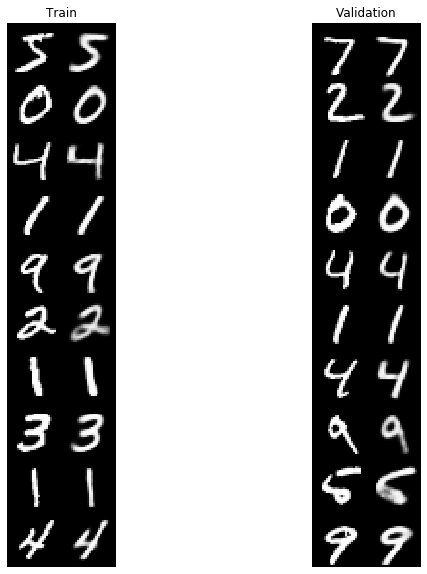

In [0]:
fig = plt.figure(figsize=(10, 10))
for fid_idx, (x_data, y_data, title) in enumerate(
            zip([x_train_dense, x_test_dense], [y_train_dense, y_test_dense], ['Train', 'Validation'])):
    n = 10  # figure with 10 x 2 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * 2))
    decoded = sess.run(cond_x_decoded_mean,
                       feed_dict={x: x_data[:batch_size, :],
                                  label: y_data[:batch_size, :]})
    for i in range(10):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = x_data[i, :].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()

## Conditionally hallucinate data
**Task 5.2** Implement the conditional sampling from the distribution $p(x \mid t, \text{label})$ by firstly sampling from the prior $p(t)$ and then sampling from the likelihood $p(x \mid t, \text{label})$.

In [0]:
n_samples = 20
# Prepare one hot labels of form
#   0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 ...
# to sample five zeros, five ones, etc
curr_labels = np.eye(10)
curr_labels = np.repeat(curr_labels, n_samples // 10, axis=0)  # Its shape is 50 x 10.
# print(curr_labels)
# YOUR CODE HERE.
# ...
# cond_sampled_im_mean is a tf.Tensor of size 50 x 784 with 5 random zeros,
# then 5 random ones, etc sampled from the cvae model.
# cond_sampled_im_mean = 
prior_t = tfd.MultivariateNormalDiag(loc=tf.zeros([n_samples,latent_dim]))
sample_t = prior_t.sample()
sample_t_label = tf.concat([sample_t, curr_labels],axis=-1)
print(sess.run(sample_t_label))
cond_sampled_im_mean = cond_decoder(sample_t_label)

[[ 1.5056736   0.12010657 -1.4199903  -0.10526315  0.44131663  2.043138
   0.5251358  -1.1824924   0.25637257  0.90660703  1.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-1.4638103  -0.07130107  0.55611897  0.93502116  0.445189   -0.3435251
   0.9156307  -0.8569715   0.7934685   1.3802345   1.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.3210632  -1.3427982  -1.1808075   0.3140964   0.65188956  0.50265557
   0.17253415  0.19379136 -0.43421912 -0.5429005   0.          1.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-1.5384252  -1.4509459   0.5902274  -1.4521512  -0.9811215   0.4166967
   0.7022445   0.2685757  -1.1132416  -1.1588589   0.          1.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-0.9719516   0.8333836   0.1542716  -1.3302513  -0.21010391  0.6247284

IndexError: ignored

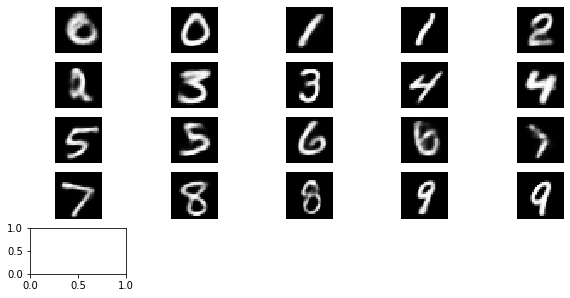

In [0]:
cond_sampled_im_mean_np = sess.run(cond_sampled_im_mean)
# Show the sampled images.
plt.figure(figsize=(10, 10))
global_idx = 0
for digit in range(10):
    for _ in range(5):
        ax = plt.subplot(10, 5, global_idx + 1)
        plt.imshow(cond_sampled_im_mean_np[global_idx, :].reshape(28, 28), cmap='gray')
        ax.axis('off')
        global_idx += 1
plt.show()

In [0]:
# Submit Task 5 (both 5.1 and 5.2).
grader.submit_conditional_hallucinating(sess, cond_sampled_im_mean)

Current answer for task 5.1 (conditional hallucinating mean) is: 0.07860522322393809
Current answer for task 5.2 (conditional hallucinating var) is: 0.035651211880399


# Authorization & Submission
To submit assignment parts to Cousera platform, please, enter your e-mail and token into variables below. You can generate a token on this programming assignment's page. <b>Note:</b> The token expires 30 minutes after generation.

In [0]:
STUDENT_EMAIL =  'kleinekrokodil@yandex.ru' # EMAIL HERE
STUDENT_TOKEN =  'qJdfqBRVQCE85JFf' # TOKEN HERE
grader.status()

You want to submit these numbers:
Task 1 (vlb): 157.59705
Task 2.1 (samples mean): -0.11856712
Task 2.2 (samples var): 0.036918394
Task 3 (best val loss): 113.8767520904541
Task 4.1 (hallucinating mean): 0.13873906
Task 4.2 (hallucinating var): 0.107835814
Task 5.1 (conditional hallucinating mean): 0.07860522322393809
Task 5.2 (conditional hallucinating var): 0.035651211880399


In [0]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# Playtime (UNGRADED)
Once you passed all the tests, modify the code above to work with the mixture of Gaussian distributions (in contrast to the mixture of Binomial distributions), and redo the experiments with CIFAR-10 dataset, which are full-color natural images with much more diverse structure.

In [0]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


[7]


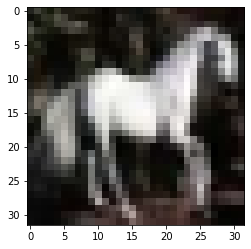

In [0]:
k = 13
plt.imshow(x_test[k])
print(y_test[k])
plt.show()

In [0]:
# horse_indices 
x_train_horses = x_train[None,7]
x_test_horses = x_test[None,13]

for i in range(8,len(y_train)):
    if y_train[i] == 7:
      x_train_horses = np.append(x_train_horses,x_train[None,i],axis=0)

for i in range(14,len(y_test)):
    if y_test[i] == 7:
      x_test_horses = np.append(x_test_horses,x_test[None,i],axis=0)

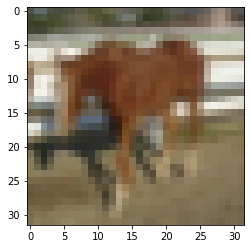

(1000, 32, 32, 3)

In [0]:
k = 15
plt.imshow(x_test_horses[k])
plt.show()
x_test_horses.shape

In [0]:
def vlb_gaussian(x, x_decoded_mean, x_decoded_log_var, t_mean, t_log_var):
    """Returns the value of negative Variational Lower Bound
    
    The inputs are tf.Tensor
        x: (batch_size x number_of_pixels_height x number_of_pixels_width x number_of_channels) matrix with one image per row with flatten channels (x_ijk)
        x_decoded_mean: (batch_size x number_of_pixels_height x number_of_pixels_width x number_of_channels) mean of the distribution p(x | t), real numbers from 0 to 1 (x_decoded_mean_ijk)
        x_decoded_log_var: (batch_size x number_of_pixels_height x number_of_pixels_width x number_of_channels) log var of x_decoded_ijk pixel-channel (x_decoded_log_var_ijk)
        t_mean: (batch_size x latent_dim) mean vector of the (normal) distribution q(t | x) (t_mean_i)
        t_log_var: (batch_size x latent_dim) logarithm of the variance vector of the (normal) distribution q(t | x) (t_log_var_i)
    
    Returns:
        A tf.Tensor with one element (averaged across the batch), VLB
    """
    ### YOUR CODE HERE
    M = int(x.shape[0])
    
    #!!!x_decoded_log_var is actually x_decoded_VAR!!!
    log_likelihood = -0.5 * tf.reduce_sum(( tf.log(2*np.pi) + tf.math.log(x_decoded_log_var) + ((x - x_decoded_mean)**2) /  x_decoded_log_var)) 
    
    KL = 0.5 * tf.reduce_sum(-t_log_var + tf.math.square(t_mean) + tf.math.exp(t_log_var) - 1)
    
    VLB = (log_likelihood - KL) / M

    return -VLB

In [0]:
def vlb_mse_kl(x, x_decoded_mean, t_mean, t_log_var, reconstruction_weight=1000):
    """Returns the value of negative Variational Lower Bound
    
    The inputs are tf.Tensor
        x: (batch_size x number_of_pixels_height x number_of_pixels_width x number_of_channels) matrix with one image per row with flatten channels (x_ijk)
        x_decoded_mean: (batch_size x number_of_pixels_height x number_of_pixels_width x number_of_channels) mean of the distribution p(x | t), real numbers from 0 to 1 (x_decoded_mean_ijk)
        x_decoded_log_var: (batch_size x number_of_pixels_height x number_of_pixels_width x number_of_channels) log var of x_decoded_ijk pixel-channel (x_decoded_log_var_ijk)
        t_mean: (batch_size x latent_dim) mean vector of the (normal) distribution q(t | x) (t_mean_i)
        t_log_var: (batch_size x latent_dim) logarithm of the variance vector of the (normal) distribution q(t | x) (t_log_var_i)
    
    Returns:
        A tf.Tensor with one element (averaged across the batch), VLB
    """
    ### YOUR CODE HERE
    M = int(x.shape[0])

    log_likelihood = -0.5 * reconstruction_weight * tf.reduce_sum((x - x_decoded_mean)**2)
    
    KL = 0.5 * tf.reduce_sum(-t_log_var + tf.math.square(t_mean) + tf.math.exp(t_log_var) - 1)
    
    VLB = (log_likelihood - KL) / M

    return -VLB

In [0]:
# x = tf.constant(x_train_dense[:1])
# x_decoded_mean = tf.math.abs(x)+0.1
# x_decoded_log_var = tf.math.log(x_decoded_mean/10)
# t_mean = tfd.MultivariateNormalDiag(loc=tf.zeros((100,3)))
# t_mean = t_mean.sample()
# t_log_var = tf.math.log(tf.math.abs(t_mean) / 10)
# # sess.run( x )

# sess.run(vlb_gaussian(x, x_decoded_mean, x_decoded_log_var, t_mean, t_log_var))

-132.29288

In [0]:
batch_size = 20
cifar_dim = (32,32,3)
latent_dim = 128 # d, dimensionality of the latent code t.
epochs = 100
learning_rate = 0.0001

x_cifar = Input(batch_shape=(batch_size, *cifar_dim))

def create_encoder_cifar(input_dim):
  encoder = Sequential(name='encoder_cifar')
  encoder.add(InputLayer(input_dim))
  encoder.add(Conv2D(filters = 64, kernel_size=5, strides=2, padding='same',use_bias=False))
  encoder.add(BatchNormalization(axis=-1))
  encoder.add(Activation('relu'))
  encoder.add(Conv2D(filters = 128, kernel_size=5, strides=2, padding='same',use_bias=False))
  encoder.add(BatchNormalization(axis=-1))
  encoder.add(Activation('relu'))
  encoder.add(Flatten())
  encoder.add(Dense(2 * latent_dim, name='output'))
  return encoder

get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])

encoder_cifar = create_encoder_cifar(cifar_dim)

h_cifar = encoder_cifar(x_cifar)

t_mean_cifar = get_t_mean(h_cifar)
t_log_var_cifar = get_t_log_var(h_cifar)

# Sampling from the distribution 
#     q(t | x) = N(t_mean, exp(t_log_var))
# with reparametrization trick.
def sampling(args):
    """Returns sample from a distribution N(args[0], diag(args[1]))
    
    The sample should be computed with reparametrization trick.
    
    The inputs are tf.Tensor
        args[0]: (batch_size x latent_dim) mean of the desired distribution
        args[1]: (batch_size x latent_dim) logarithm of the variance vector of the desired distribution
    
    Returns:
        A tf.Tensor of size (batch_size x latent_dim), the samples.
    """
    t_mean, t_log_var = args
    # YOUR CODE HERE
    epsilon = tfd.MultivariateNormalDiag(loc=tf.zeros(t_mean.shape))
    latent = tfp.bijectors.Affine(shift=t_mean,  scale_diag=tf.math.exp(.5 * t_log_var))
    latent = latent(epsilon)
    return latent.sample()

t_cifar = Lambda(sampling)([t_mean_cifar, t_log_var_cifar])

def create_decoder_cifar(input_dim):
  decoder = Sequential(name='decoder_cifar')
  decoder.add(InputLayer([input_dim]))
  decoder.add(Dense(128 * 8 * 8))
  decoder.add(Reshape((8, 8, 128)))
  decoder.add(Conv2DTranspose(kernel_size=5, filters=128, strides=2, padding='same', use_bias=False, name='deconv'))
  decoder.add(BatchNormalization(axis=-1))
  decoder.add(Activation('relu'))
  decoder.add(Conv2DTranspose(kernel_size=5, filters=64, strides=2,  use_bias=False, padding='same'))                                         
  decoder.add(BatchNormalization(axis=-1))
  decoder.add(Activation('relu'))
  decoder.add(Conv2DTranspose(kernel_size=5, filters=3, padding='same'))
  return decoder

get_x_decoded_mean_cifar = Lambda(lambda x: tf.math.sigmoid(x[:,:,:,:3]))
# # get_x_decoded_log_var_cifar1 = Lambda(lambda x: (x[:,:,:,3:]))
# # get_x_decoded_log_var_cifar2 = Activation('sigmoid')

decoder_cifar = create_decoder_cifar(latent_dim)

out = decoder_cifar(t_cifar)

x_decoded_mean_cifar = get_x_decoded_mean_cifar(out)
# x_decoded_log_var_cifar = get_x_decoded_log_var_cifar1(out)
# x_decoded_log_var_cifar = get_x_decoded_log_var_cifar2(x_decoded_log_var_cifar1)

In [0]:
loss_cifar = vlb_mse_kl(x_cifar, x_decoded_mean_cifar,  t_mean_cifar, t_log_var_cifar, reconstruction_weight=1)

vae_cifar = Model(x_cifar, x_decoded_mean_cifar)
# Keras will provide input (x) and output (x_decoded_mean) to the function that
# should construct loss, but since our function also depends on other
# things (e.g. t_means), it is easier to build the loss in advance and pass
# a function that always returns it.
vae_cifar.compile(optimizer=keras.optimizers.RMSprop(lr=learning_rate), loss=lambda x, y: loss_cifar)

In [0]:
# train the VAE on MNIST digits

x_train_cifar = x_train_horses.astype('float32') / 255.
x_test_cifar = x_test_horses.astype('float32') / 255.


In [0]:
hist_cifar = vae_cifar.fit(x=x_train_cifar, y=x_train_cifar,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_test_cifar, x_test_cifar),
               verbose=2)

Train on 5000 samples, validate on 1000 samples
Epoch 1/100
 - 4s - loss: 88.3499 - val_loss: 78.9318
Epoch 2/100
 - 3s - loss: 68.4527 - val_loss: 71.2404
Epoch 3/100
 - 3s - loss: 63.6617 - val_loss: 61.9479
Epoch 4/100
 - 3s - loss: 60.4891 - val_loss: 59.6238
Epoch 5/100
 - 3s - loss: 59.0623 - val_loss: 58.7684
Epoch 6/100
 - 3s - loss: 58.1363 - val_loss: 57.0298
Epoch 7/100
 - 3s - loss: 57.2407 - val_loss: 60.2964
Epoch 8/100
 - 3s - loss: 56.5232 - val_loss: 56.1655
Epoch 9/100
 - 3s - loss: 56.0453 - val_loss: 55.5266
Epoch 10/100
 - 3s - loss: 55.6741 - val_loss: 57.0207
Epoch 11/100
 - 3s - loss: 55.2470 - val_loss: 54.5692
Epoch 12/100
 - 3s - loss: 55.1538 - val_loss: 54.7425
Epoch 13/100
 - 3s - loss: 54.5699 - val_loss: 54.8554
Epoch 14/100
 - 3s - loss: 54.4497 - val_loss: 53.8746
Epoch 15/100
 - 3s - loss: 53.9812 - val_loss: 53.4587
Epoch 16/100
 - 3s - loss: 53.9965 - val_loss: 53.3990
Epoch 17/100
 - 3s - loss: 53.8532 - val_loss: 54.5828
Epoch 18/100
 - 3s - loss:

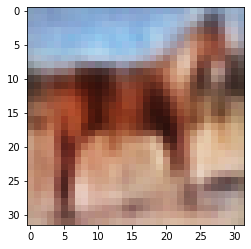

In [0]:
plt.imshow(sess.run(x_decoded_mean_cifar, feed_dict={x_cifar: x_train_cifar[:10]})[4])
plt.show()

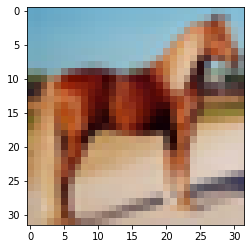

In [0]:
plt.imshow(x_train_cifar[4])
plt.show()

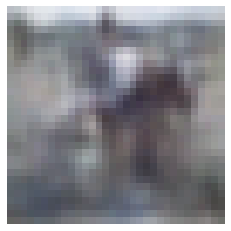

In [0]:
n_samples = 1  # To pass automatic grading please use at least 2 samples here.
# YOUR CODE HERE.

prior_t = tfd.MultivariateNormalDiag(loc=tf.zeros([n_samples,latent_dim]))
sample_t = prior_t.sample()
# print(sess.run(sample_t))
sampled_im_mean = decoder_cifar(sample_t)
sampled_im_mean = get_x_decoded_mean_cifar(sampled_im_mean)
sampled_im_mean_np = sess.run(sampled_im_mean)
# Show the sampled images.
plt.figure()
for i in range(n_samples):
    ax = plt.subplot(n_samples, 1, i + 1)
    plt.imshow(sampled_im_mean_np[i, :])
    ax.axis('off')
plt.show()

In [0]:
batch_size = 100
original_dim = 784 # Number of pixels in MNIST images.
latent_dim = 100 # d, dimensionality of the latent code t.
intermediate_dim = 512 # Size of the hidden layer.

learning_rate = 0.001
epochs = 20

def create_encoder(input_dim):
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer([input_dim]))
    encoder.add(Dense(intermediate_dim, activation='relu'))
    encoder.add(Dense(intermediate_dim, activation='relu'))
    encoder.add(Dense(2 * latent_dim))
    return encoder

def sampling(args):
    var = args
    epsilon = tfd.MultivariateNormalDiag(loc=tf.zeros(t_mean.shape))
    latent = tfp.bijectors.Affine(shift=t_mean,  scale_diag=tf.math.exp(.5 * t_log_var))
    latent = latent(epsilon)
    return latent.sample()

def create_decoder(input_dim):
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer([input_dim]))
    decoder.add(Dense(intermediate_dim, activation='relu'))
    decoder.add(Dense(intermediate_dim, activation='relu'))
    decoder.add(Dense(2 * original_dim))
    return decoder

get_t_mean = Lambda(lambda h: h[:,:latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])

get_x_decoded_mean = Lambda(lambda h: tf.math.sigmoid(h[:, :original_dim]))
get_x_decoded_log_var = Lambda(lambda h: 0.1 * tf.math.sigmoid(h[:, original_dim:]))

x = Input(batch_shape=(batch_size, original_dim))
encoder = create_encoder(original_dim)
sampling = Lambda(sampling)
decoder = create_decoder(latent_dim)

h = encoder(x)
t_mean = get_t_mean(h)
t_log_var = get_t_log_var(h)
t = sampling([t_mean, t_log_var])
out = decoder(t)
x_decoded_mean = get_x_decoded_mean(out)
x_decoded_log_var = get_x_decoded_log_var(out)


In [0]:
loss = vlb_gaussian(x, x_decoded_mean, x_decoded_log_var, t_mean, t_log_var)
vae = Model(x, x_decoded_mean)
vae.compile(optimizer=keras.optimizers.RMSprop(lr=learning_rate), loss=lambda x, y: loss)

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

y_train_dense = np_utils.to_categorical(y_train)
y_test_dense = np_utils.to_categorical(y_test)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train_dense = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_dense = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [0]:
hist = vae.fit(x=x_train_dense, y=x_train_dense,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_test_dense, x_test_dense),
               verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 5s - loss: 746.1654 - val_loss: 744.9329
Epoch 2/20
 - 3s - loss: 744.0440 - val_loss: 743.0832
Epoch 3/20
 - 3s - loss: 742.1737 - val_loss: 741.3251
Epoch 4/20
 - 3s - loss: 741.0476 - val_loss: 740.5535
Epoch 5/20
 - 3s - loss: 740.5250 - val_loss: 740.3891
Epoch 6/20
 - 3s - loss: 740.2328 - val_loss: 740.0032
Epoch 7/20
 - 4s - loss: 740.0072 - val_loss: 739.8477
Epoch 8/20
 - 3s - loss: 739.8328 - val_loss: 739.7352
Epoch 9/20
 - 4s - loss: 739.7321 - val_loss: 739.6448
Epoch 10/20
 - 3s - loss: 739.6340 - val_loss: 739.5579
Epoch 11/20
 - 3s - loss: 739.5678 - val_loss: 739.4198
Epoch 12/20
 - 3s - loss: 739.4897 - val_loss: 739.3713
Epoch 13/20
 - 3s - loss: 739.4355 - val_loss: 739.2815
Epoch 14/20
 - 3s - loss: 739.3721 - val_loss: 739.4581
Epoch 15/20
 - 3s - loss: 739.3343 - val_loss: 739.2501
Epoch 16/20
 - 3s - loss: 739.2954 - val_loss: 739.3147
Epoch 17/20
 - 3s - loss: 739.2696 - val_loss: 739.1382
Epoch 1

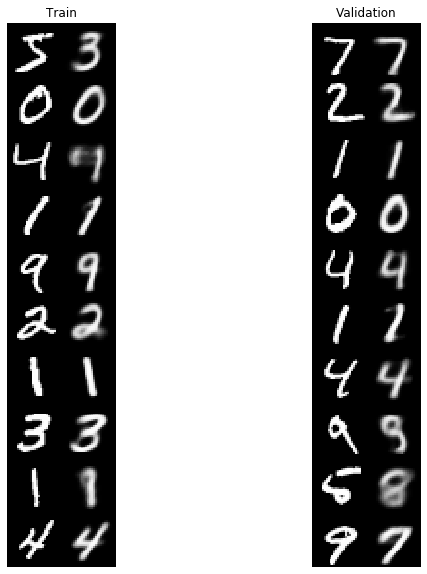

In [0]:
fig = plt.figure(figsize=(10, 10))
for fid_idx, (data, title) in enumerate(
            zip([x_train_dense, x_test_dense], ['Train', 'Validation'])):
    n = 10  # figure with 10 x 2 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * 2))
    decoded = sess.run(x_decoded_mean, feed_dict={x: data[:batch_size, :]})
    for i in range(10):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = data[i, :].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()